In [4]:
import numpy as np
import os

# to make output stable
np.random.seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
# To make the same results as in the book

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [12]:
X, y = mnist["data"], mnist["target"]  # X is the data of image(28*28 pixels from 0 to 255 black intensity), while y is label
random_d = X[42]

(-0.5, 27.5, 27.5, -0.5)

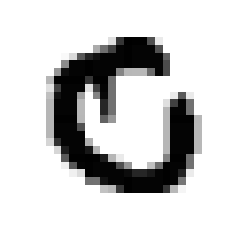

In [20]:
random_d = random_d.reshape(28, 28) # it's 1-D array, for imshow we need 2-D array
plt.imshow(random_d, cmap=mpl.cm.binary)
plt.axis('off') # without the axis

In [21]:
y[42]

0

In [39]:
random_values = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]] # contacatanate
changed_arr = []
for value in random_values:
    changed_arr.append(value.reshape(28, 28))
full_image = np.concatenate(changed_arr, axis=0)  # concatenate to show all
plt.imshow(full_image, cmap=mpl.cm.binary)
plt.axis('off') # without the axis
plt.show()

ValueError: cannot reshape array of size 39200 into shape (28,28)

In [150]:
# First 60.000 images are for train set, last 10.000 for test
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [34]:
# We have an order, it can be dangerous, so let's shuffle and make everything without order
shuffled_ixs = np.random.permutation(60000) # we randomly take the array of indexes
X_train, y_train = X_train[shuffled_ixs], y_train[shuffled_ixs]

In [35]:
# Binary classifier, true only for 7-digit
y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)

In [37]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42, max_iter = 5, tol=-np.infty)
sgd.fit(X_train, y_train_7)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [44]:
example_digit = X[60000]
sgd.predict([example_digit])

array([False])

This how `cross_val_score()` works in sklearn

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=42)  # helps to find unbiased sets,
# because we can take one gruoup more than another

for train_index, test_index in skfolds.split(X_train, y_train_7):
    # using only train data, because we are cross-validating
    clone_sgd = clone(sgd)
    X_train_strat = X_train[train_index]
    y_train_strat = y_train_7[train_index]
    X_test_strat = X_train[test_index]
    y_test_strat = y_train_7[test_index]
    
    clone_sgd.fit(X_train_strat, y_train_strat)
    y_strat_predicted = clone_sgd.predict(X_test_strat)
    n_correct = sum(y_strat_predicted == y_test_strat)
    print(n_correct / len(y_test_strat))

0.9798333333333333
0.979
0.9588333333333333
0.9430833333333334
0.9716666666666667


## Recall and precision

In [48]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_7, cv=5, scoring='accuracy')

array([0.97983333, 0.979     , 0.95883333, 0.94308333, 0.97166667])

Although the accuracy may seem encoraging, actually even the dumb classifier, that classifies everything as non-7 has 90% percent accuracy.<br>
So, accuracy is not a good thing for classifiers.

We can use confusion matrix to see how much values that should of given 7 gave us different numbers from other groups.For that we must take predictions using `cross_val_predict` and compare them with `confusion matrix`.

In [49]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_predicted = cross_val_predict(sgd, X_train, y_train_7, cv=5)
confusion_matrix(y_train_7, y_train_predicted)

array([[52264,  1471],
       [  540,  5725]], dtype=int64)

Rows represent the classe(true or false), while columns show the predicted class(non-7 and 7).<br>
So, we have 52264 correctly shown non-7(*true negative*), 1471 incorrect ones(that were classified as 7, but should of benn non-7)(*false positive*).The second row shows us that we guessed 540 7-ns incorrectly(the should be non-7)(*false negative*), while 5725 are correct(*true positive*).

We can evaluate our method via percision(TP/TP+FP) or recall(TP/TP+FN).Sometimes one is more important than another.For example, in medicine recall is much more important to the health of the patient, because if disease was not found, it can lead to death.In investment, however, precision is more likely to be to use, because people are more concerned about the loss of money, than alternatives.<br>
F1-score is used to compare 2 of those, using harmonical mean(gives more weigth to lower values), so the bigger they both are, the closer it is to the max(2/(1/precision) + (1/recall)

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_train_7, y_train_predicted)
recall = recall_score(y_train_7, y_train_predicted)
f1 = f1_score(y_train_7, y_train_predicted)
[precision, recall, f1]

[0.7955808782657031, 0.9138068635275339, 0.8506054527895401]

But it gives the same weigth to both metrics, sometimes it's more important to have only one.But if recall goes up, the precision goes down.It is called precesion/recall tradeoff

This is important concept, to understand which we need to figure out how SGDClassifier works.It takes the scores of the numbers(the probability it belongs to the class) and, according to threshold, classifies them.So, to have better precision we must raise our threshold(the numbers with less probability will be dissmissed => lower chances to be false), but at the same time it lowers recall, because some true numbers also can't reach the threshold => recall will drop.

In [52]:
y_scores = sgd.decision_function([example_digit])
y_scores

array([-321136.3445365])

The standard for SGDClassifier is 0, let's move the threshold lower to see that it will accept inccorrect number(precision will be lower), but the number of correct ones will increase as well.

In [56]:
threshold = -400000
y_prediction_result = (y_scores > threshold)
y_prediction_result

array([ True])

Compute the scores for each instance using `cross_val_predict` with `decision_function` as a return.<br>
It takes several sets and compares results between each other.Than we using `percision_recall_curve()` we can compute the values(including threshold).

In [59]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd, X_train, y_train_7, cv=3, method='decision_function')
precision, recalls, thresholds = precision_recall_curve(y_train_7, y_scores)

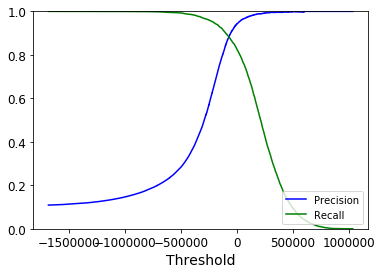

In [68]:
def plot_precision_recall_function(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], 'blue', label='Precision')
    plt.plot(threshold, recall[:-1], 'green', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower right')
    plt.ylim([0, 1])
plot_precision_recall_function(precision, recalls, thresholds)

Let's go with around 0.6 percision.Then threshold is ~ -230.000.But we must keep in mind that trully sharp classifiers must take both recall and percision in considertaion(if one value is too low, it can deem pointless).

In [75]:
y_train_60 = (y_scores > -230000)
precision_score(y_train_7, y_train_60)
recall_score(y_train_7, y_train_60)

0.9554668794892258

## ROC curve

There is also another tool to find correct recall rate, which compares to values, from which recall consists: *True Positive* and *False Positive* values.Because of the trade-off, from specific point of time errors correspondengly increase.The evaluation function is called *Reciver Operating Characteristic* curve(ROC).The perfect curve stay as far away from diagonal as possible.To measure the function we compute the Area Under Curbe(AUC). <br>
ROC plots sensivity(recall) versus True Negative Rate(1 - TNR = FTR), which is also called specifity. 

In [76]:
from sklearn.metrics import roc_curve
fp_rate, tp_rate, threshold = roc_curve(y_train_7, y_scores)

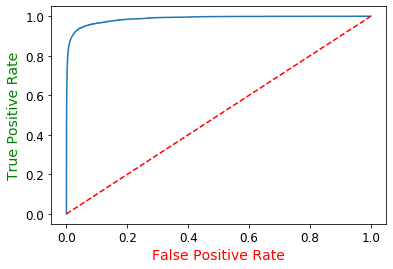

In [87]:
def plot_roc_curve(fpr, tpr, title=None):
    plt.plot(fpr, tpr, label=title)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('True Positive Rate', color='green')
    plt.xlabel('False Positive Rate', color='red')
plot_roc_curve(fp_rate, tp_rate)

In [80]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_train_7, y_scores)

0.9874769736590495

We use PR when we care about false positives or when positives are rare.In our case PR will be better, because we care about positives(percision).If we cared about negatives(recall), we should of taken ROC.

Let's compare to Random Forest Classifier.

In [82]:
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier(random_state=42)
forest_proba = cross_val_predict(rand_forest, X_train, y_train_7, cv=3, method='predict_proba')
forest_proba

C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[1. , 0. ],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.9, 0.1]])

In [85]:
# use positive class as the score(probability doen't suit us).We recieve
# the probability that the num is non-7 and 7, so positive, that tells us about 7, is okay.
y_scores_forest = forest_proba[:, 1]
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_7, y_scores_forest)

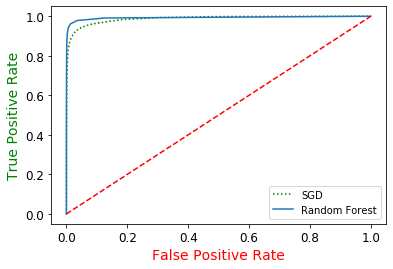

In [89]:
plt.plot(fp_rate, tp_rate, 'g:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend()
plt.show()

In [94]:
print(roc_auc_score(y_train_7, y_scores_forest))
y_pred_forest = forest_proba = cross_val_predict(rand_forest, X_train, y_train_7, cv=3)
print(precision_score(y_train_7, y_pred_forest))
print(recall_score(y_train_7, y_pred_forest))

0.9930151743009482


C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9837470976960171
0.879169992019154


This way we can compare many models with each other

## Multiclass classifier

Earlier we used binary classifier, because it only checked 2 possible solution to the problem: either it is a number, or it isn't.Multiclass classifiers work for multiply classes.<br>
There are some that are capable for multiclass(Random Forest), and some that are only for binary class(Support Vector Machine(*SVM*)).We can use binary classifiers and run them multiply times to create multiclass.There are two strategies to it: either compare each individually and select the one with the highest score(1, non-1, 2, non-2,....), which is called *one versus all(OvA)*, or compare pairs(1 and 2, 2 and 3...), which is called *one versus one(OvO)*.Obviously, the second one is working longer, but it's preferabale for some algorithms, that can't handle large data, like SVM.

SGD can be used to train multiply classes.It actually uses the OvA method, training 10 binary classifiers and selecting the one with the highest score.

In [95]:
sgd.fit(X_train, y_train)
sgd.predict([example_digit])

array([0], dtype=int8)

In [97]:
all_scores = sgd.decision_function([example_digit])
all_scores  # the highest score is 0, so it takes it's value

array([[ 319563.29672886, -823318.47411973, -269431.67432333,
        -450986.03848791, -654500.61417807, -349623.58029053,
        -171660.50793991, -294303.83427802, -259613.01223139,
        -410588.30594801]])

In [98]:
sgd.classes_  # we are lucky to get convenient classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [99]:
# That's how we can use OneVsOne method.
from sklearn.multiclass import OneVsOneClassifier
ovo_class = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_class.fit(X_train, y_train)
ovo_class.predict([example_digit])

array([0], dtype=int8)

In [103]:
len(ovo_class.estimators_)

45

Random Forest doen't use such methods and immideatly assumes a class.

In [105]:
rand_forest.fit(X_train, y_train)
rand_forest.predict([example_digit])

array([0], dtype=int8)

In [106]:
rand_forest.predict_proba([example_digit])

array([[0.9, 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ]])

In [107]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

array([0.84993001, 0.81769088, 0.84707706])

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91211758, 0.9099955 , 0.90643597])

## Error analysis

Let's use confusion matrix to evaluate error.

In [110]:
y_train_pred = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
y_train_pred

array([1, 6, 6, ..., 0, 2, 9], dtype=int8)

In [111]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5749,    4,   22,   11,   11,   40,   36,   11,   36,    3],
       [   2, 6490,   43,   24,    6,   41,    8,   12,  107,    9],
       [  53,   42, 5330,   99,   87,   24,   89,   58,  159,   17],
       [  46,   41,  126, 5361,    1,  241,   34,   59,  129,   93],
       [  20,   30,   35,   10, 5369,    8,   48,   38,   76,  208],
       [  73,   45,   30,  194,   64, 4614,  106,   30,  170,   95],
       [  41,   30,   46,    2,   44,   91, 5611,    9,   43,    1],
       [  26,   18,   73,   30,   52,   11,    4, 5823,   14,  214],
       [  63,  159,   69,  168,   15,  172,   54,   26, 4997,  128],
       [  39,   39,   27,   90,  177,   40,    2,  230,   78, 5227]],
      dtype=int64)

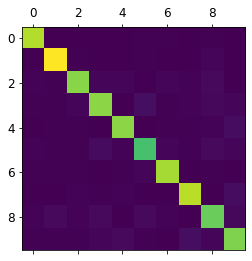

In [112]:
plt.matshow(conf_mx)
plt.show()

5 is not as bright as other.So it can mean either that there are few instances of 5-s or that there is a good miscalculation.This time it's both

In [115]:
# let's look at the errors to see where we can improve
rows_sum = conf_mx.sum(axis=1)
norm_conf_matrix = conf_mx / rows_sum  # instead of the absolute number of erros, which makes big classe look bad

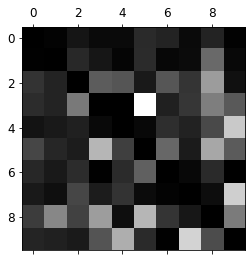

In [121]:
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)

8 and 9 rows are bright, which tells us the have quite a few errors.We can write algorithm(to look for the loops in the digit) or preprocess the images(to make this loops stand out more)

In [122]:
# analyse individual errors
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

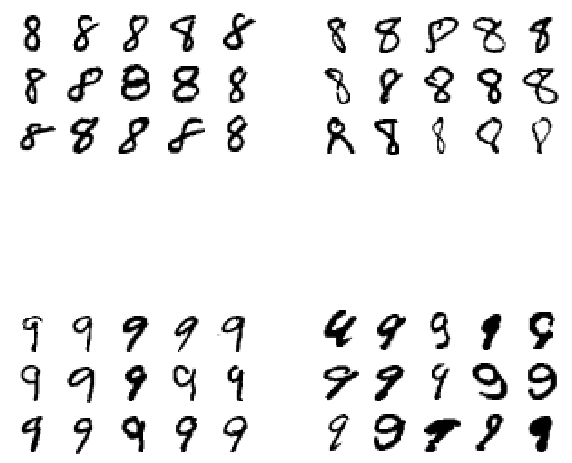

In [136]:
class_8, class_9 = 8, 9
class_88 = X_train[(y_train == class_8) & (y_train_pred == class_8)]
class_89 = X_train[(y_train == class_8) & (y_train_pred == class_9)]
class_99 = X_train[(y_train == class_9) & (y_train_pred == class_9)]
class_98 = X_train[(y_train == class_9) & (y_train_pred == class_8)]

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_digits(class_88[:15], images_per_row = 5, label='correct 8')
plt.subplot(222)
plot_digits(class_89[:15], images_per_row = 5)
plt.subplot(223)
plot_digits(class_99[:15], images_per_row = 5)
plt.subplot(224)
plot_digits(class_98[:15], images_per_row = 5)

## Multilabel classification
Can check wether or not num can be applied to the different categories(2 categories can be valid).For example:

In [139]:
from sklearn.neighbors import KNeighborsClassifier

small_category = (y_train <= 3)
even_category = (y_train % 2 == 0)
multilabel = np.c_[small_category, even_category]

knn_alg = KNeighborsClassifier()
knn_alg.fit(X_train, multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [141]:
knn_alg.predict([example_digit])  # num is 0

array([[ True,  True]])

F1 score puts the same weight on every digit, but 1 may be seen more often than another 

In [142]:
# Evaluate via F1 score(2/(1/recall) + 1/(perciiiision))
y_rain_knn_predict = cross_val_predict(knn_alg, X_train, y_train, cv=3)
f1_score(y_train, y_rain_knn_predict)

KeyboardInterrupt: 

## Multioutput classifiers.
They output not just 2, but multiple values, just like with the case of multilabel calssifiers.Sp, we can, for example, build an classifier to clear the noise of the image.

ValueError: cannot reshape array of size 28 into shape (28,28)

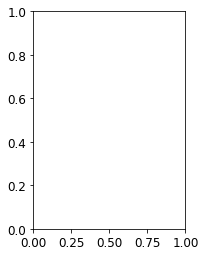

In [151]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_modified = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_modified = X_test + noise
y_train_mod = y_train
y_test_mod = y_test


X_train_modified

rand_index = 2500
plt.subplot(121);
plot_digits(X_test_modified[rand_index].reshape(28, 28))
plt.subplot(122);
plot_digits(y_test_mod[rand_index].reshape(28, 28))


In [ ]:
rand_index = 2500
knn_alg.fit(X_train_modified, y_train_mod)
cleaned_digit = knn_alg.predict(X_test_modified[rand_index])

## Excercises

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knc_advanced = KNeighborsClassifier()
parameters = {'weights' : ['uniform', 'distance'], 'n_neighbors' : [2, 3, 4, 5]}
grid = GridSearchCV(kiinc_advanced, parameters)
grid.fit(X_train, y_train)
sorted(grid.sv_result_.keys())

In [161]:
print(sorted(grid.best_params))

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [ ]:
knc_tuned = KNeighborsClassifier(weights= , n_neighbours = )

knc_tuned.fit(X_train, y_train)
y_train_advanced = knc_tuned.predict(X_train)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_train, y_train_advanced)
recall = recall_score(y_train, y_train_advanced)
f1 = f1_score(y_train, y_train_advanced)
[precision, recall, f1]

In [163]:
def create_duplicates(data):
    print(data[0])
    # left
    first_add_on = data[0].copy()
    for i in range(255):
        if data[0][i] != 0 and i > 0 and i <= 255:
            data[0][i - 1] = data[0][i]
    print(first_add_on)
create_duplicates(X_train)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0.   0.   0.   0.   0.   0.
   0. 

## Titanic

In [205]:
import pandas as pd
titanic_train = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [174]:
from sklearn.model_selection import StratifiedShuffleSplit
y_train = titanic_test['Survived']
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [189]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ignore cabin for now, replace nulls in the age groupd by medians.Tickets and names are useless for now.

In [190]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only 38% survived, it means that accuracy can be used(because it's a sum of thruth to the total: it's not an class-imbalanced data, so it's pretty safe to use).<br>
Mean age is 30.

In [191]:
titanic_train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Explore categorical data and build pipeline

In [194]:
print(titanic_train["Embarked"].value_counts())
print(titanic_train["Pclass"].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64


To work OK with the sklearn, pipeline, which is essentially the transformer, must have .fit, .transform, .fit_tranform, .set_params and .get_params. The last two we get from inheriting BaseEstimator, and the fit_tranform from inhereting TransformerMixin(fit and tranform will be explicitly written in the function-tranformer.[Got info from](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65)

In [233]:
from sklearn.base import BaseEstimator, TransformerMixin

# a class to select columns(numerical and categorical)
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):  # attributes are the columns to select
        self.attributes = attributes
    
    def fit(self, X, y=None):  # we don't do a thing, to 'sync' with sklearn
        # Explicitly declare variables if they will be given to like a normal transformer
        return self
    
    def transform(self, X):
        return X[self.attributes]

In [234]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numerical_pipeline = Pipeline([
    # Send all the numerical columns here
    ("num_selector", DataFrameSelector(['Age', 'Fare', 'Parch', 'SibSp'])),
    # replace nulls with median values
    ("imputer", SimpleImputer(strategy="median")),
])
numerical_pipeline.fit_transform(titanic_train)

array([[22.    ,  7.25  ,  0.    ,  1.    ],
       [38.    , 71.2833,  0.    ,  1.    ],
       [26.    ,  7.925 ,  0.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  2.    ,  1.    ],
       [26.    , 30.    ,  0.    ,  0.    ],
       [32.    ,  7.75  ,  0.    ,  0.    ]])

We don't have imputer for categorical variables, so let's create one based on the most frequent occurences.

In [244]:
class MostFrquent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.na_to_freq_ = pd.Series([X[i].value_counts().index[0] for i in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.na_to_freq_)

In [245]:
from sklearn.preprocessing import OneHotEncoder
categorical_pipeline = Pipeline([
    ("select_categorical", DataFrameSelector(["Embarked", "Pclass", "Sex"])),
    ("fill_na", MostFrquent()),
    ("ecode_cat", OneHotEncoder(sparse=False)),
])

In [246]:
categorical_pipeline.fit_transform(titanic_train)

array([[0., 0., 1., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.]])

In [248]:
from sklearn.pipeline import FeatureUnion
preprocessing_pipeline = FeatureUnion([
    ("num_pipe", numerical_pipeline),
    ("cat_pipe", categorical_pipeline)
])

In [251]:
X_train = preprocessing_pipeline.fit_transform(titanic_train)
X_train

array([[22.    ,  7.25  ,  0.    , ...,  1.    ,  0.    ,  1.    ],
       [38.    , 71.2833,  0.    , ...,  0.    ,  1.    ,  0.    ],
       [26.    ,  7.925 ,  0.    , ...,  1.    ,  1.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  2.    , ...,  1.    ,  1.    ,  0.    ],
       [26.    , 30.    ,  0.    , ...,  0.    ,  0.    ,  1.    ],
       [32.    ,  7.75  ,  0.    , ...,  1.    ,  0.    ,  1.    ]])

In [253]:
from sklearn.svm import SVC

svc_alg = SVC(gamma='auto')
svc_alg.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [260]:
from sklearn.model_selection import cross_val_score
svc_score = cross_val_score(svc_alg, X_train, y_train, cv=10)
svc_score.mean()

0.7365250822835092

In [261]:
from sklearn.ensemble import RandomForestClassifier

rand_for = RandomForestClassifier(n_estimators = 50)
rand_for.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [262]:
forest_score = cross_val_score(rand_for, X_train, y_train, cv=10)
forest_score.mean()

0.8126929406423787

{'whiskers': [<matplotlib.lines.Line2D at 0x1b2b940f208>,
 'caps': [<matplotlib.lines.Line2D at 0x1b2b9427a48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b2b9423948>,
 'medians': [<matplotlib.lines.Line2D at 0x1b2b9427bc8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b2b942da48>,
 'means': []}

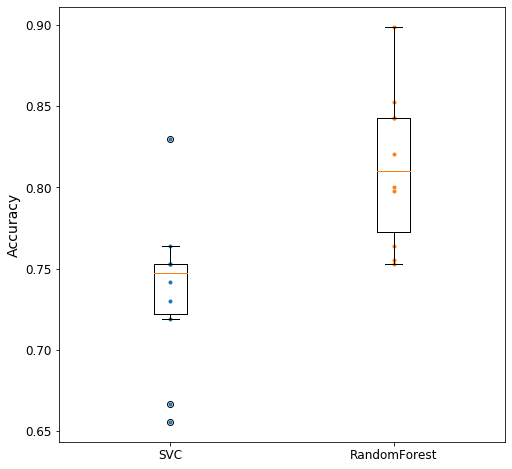

In [269]:
# let's compare accuracy
plt.figure(figsize=(8, 8))
plt.plot([1]*10, svc_score, '.')
plt.plot([2]*10, forest_score, '.')
plt.ylabel("Accuracy")
plt.boxplot([svc_score, forest_score], labels=("SVC", "RandomForest"))

Different ages may have different surviability rate.So, convert age numerical into categorical

In [272]:
titanic_train["AgeBucket"] = titanic_train["Age"] // 15*15
titanic_train[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


## Spam filter

In [273]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [274]:
fetch_spam_data()